# Hidden Markov Model

## Imports

In [112]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from scipy.stats import norm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

from pomegranate import HiddenMarkovModel, State, DiscreteDistribution

## Tratamento do data set

In [113]:
data = pd.read_csv("dataset_thyroid_sick.csv")
data = data.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured','TBG','referral_source','query_on_thyroxine'], axis=1)

#remoção de linhas com ?, substituição de valores boolean para int, assim como as da string das labels
data = data[data != '?']
data = data.dropna()
data = data.replace({'negative': 0, 'sick': 1})
data = data.replace({'t': 1, 'f': 0})
data = data.replace({'M': 1, 'F': 0})
data.reset_index(drop=True)

,age,sex,on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class
0,41,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.3,2.5,125,1.14,109,0
1,70,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.72,1.2,61,0.87,70,0
2,80,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2.2,0.6,80,0.7,115,1
3,66,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0.6,2.2,123,0.93,132,0
4,68,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2.4,1.6,83,0.89,93,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2638,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8.8,2.7,108,1.11,97,0
2639,68,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2.1,124,1.08,114,0
2640,74,0,0,0,0,0,0,0,0,1,...,0,0,0,0,5.1,1.8,112,1.07,105,0
2641,72,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.7,2,82,0.94,87,0


In [114]:
data['normTSH'] = StandardScaler().fit_transform(data['TSH'].values.reshape(-1, 1))
data['normT3'] = StandardScaler().fit_transform(data['T3'].values.reshape(-1, 1))
data['normTT4'] = StandardScaler().fit_transform(data['TT4'].values.reshape(-1, 1))
data['normT4U'] = StandardScaler().fit_transform(data['T4U'].values.reshape(-1, 1))
data['normFTI'] = StandardScaler().fit_transform(data['FTI'].values.reshape(-1, 1))
data['normAge'] = StandardScaler().fit_transform(data['age'].values.reshape(-1, 1))
data = data.drop(['TSH','T3','TT4','FTI','T4U','age'], axis=1)

In [115]:
data = data.drop(['sex','on_thyroxine','on_antithyroid_medication','pregnant','thyroid_surgery','I131_treatment','query_hyperthyroid','lithium','goitre','tumor','psych','normTSH','normFTI'], axis=1)
data = data[['normAge', 'sick', 'query_hypothyroid', 'hypopituitary', 'normT3', 'normTT4', 'normT4U', 'Class']]
data.head()

,normAge,sick,query_hypothyroid,hypopituitary,normT3,normTT4,normT4U,Class
0,-0.593285,0,0,0,0.605651,0.483484,0.734949,0
4,0.830789,0,0,0,-0.972673,-1.321686,-0.639743,0
7,1.321849,0,0,0,-1.701131,-0.785776,-1.505291,1
8,0.634365,0,0,0,0.241423,0.427073,-0.334256,0
9,0.732577,0,0,0,-0.487035,-0.701159,-0.537914,0


In [116]:
rows, columns = data.shape
print(f"There are {rows} rows and {columns} columns")

There are 2643 rows and 8 columns


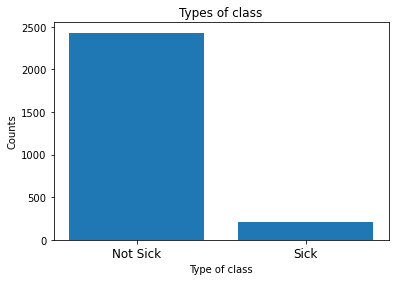

In [142]:
bars = ["0","1"]
class_counts = data.groupby("Class").Class.count()
plt.bar(x = class_counts.index, height=class_counts.values)
plt.xlabel("Type of class")
plt.ylabel("Counts")
y_pos = np.arange(len(bars))
bars = ('Not Sick','Sick')
plt.xticks(y_pos, bars, color='black', fontsize='12', horizontalalignment='center')
plt.title("Types of class")
plt.savefig('figures/unbalanced_data_bar.png')

### Box Plot da feature T3 normalizada

Percentis para Class = 0:  [-0.4870348  -0.00139646  0.48424188] 
Percentis para Class = 1:  [-1.57972107 -1.3369019  -1.21549231]


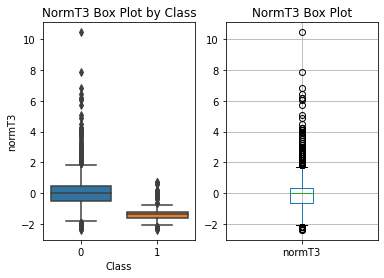

In [139]:
plt.subplot(1, 2, 1)
sns.boxplot(x = "Class", y = "normT3", data = data)
plt.title("NormT3 Box Plot by Class")
normT3_0 = np.percentile(data.loc[data['Class'] == 0, ["normT3"]], [25,50,75])
normT3_1 = np.percentile(data.loc[data['Class'] == 1, ["normT3"]], [25,50,75])
print("Percentis para Class = 0: ",normT3_0, "\nPercentis para Class = 1: ", normT3_1)
plt.subplot(1, 2, 2)
data.boxplot(column='normT3', return_type='axes');
plt.title("NormT3 Box Plot")
plt.savefig('figures/T3_boxplot.png')

### Box Plot da feature TT4 normalizada

Percentis para Class = 0:  [-0.53192385 -0.08063139  0.48348418] 
Percentis para Class = 1:  [-0.9832163  -0.5883354  -0.05242561]


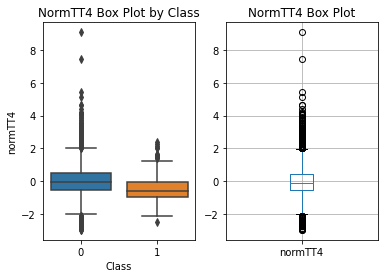

In [140]:
plt.subplot(1, 2, 1)
sns.boxplot(x = "Class", y = "normTT4", data = data)
plt.title("NormTT4 Box Plot by Class")
normTT4_0 = np.percentile(data.loc[data['Class'] == 0, ["normTT4"]], [25,50,75])
normTT4_1 = np.percentile(data.loc[data['Class'] == 1, ["normTT4"]], [25,50,75])
print("Percentis para Class = 0: ",normTT4_0,"\nPercentis para Class = 1: ", normTT4_1)
plt.subplot(1, 2, 2)
data.boxplot(column='normTT4', return_type='axes');
plt.title("NormTT4 Box Plot")
plt.savefig('figures/TT4_boxplot.png')

### NormT3 Distplot

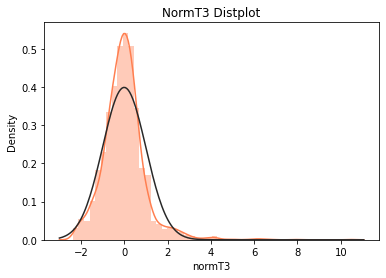

In [137]:
plt.title("NormT3 Distplot")
sns.distplot(data["normT3"], fit=norm, color="coral")
plt.savefig('figures/normT3_distoplot.png')

### NormTT4 Distplot

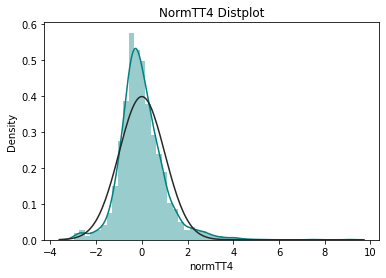

In [138]:
plt.title("NormTT4 Distplot")
sns.distplot(data["normTT4"], fit=norm, color="teal")
plt.savefig('figures/normTT4_distoplot.png')

## Separação dos dados em treino e teste

In [122]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
print("Treino: ",X_train.shape,y_train.shape,"Teste: ",X_test.shape,y_test.shape)

Treino:  (1850, 7) (1850,) Teste:  (793, 7) (793,)


## Treino e teste de classificadores de modelo

In [123]:
models_best_results = []
models_results = []
models_best_parameters = {}
cv = 5

### Logistic Regression

In [124]:
lr = LogisticRegression(random_state = 35)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
data_report = pd.DataFrame(report).transpose()
print(data_report)
print("\nConfusion Matrix\n",confusion_matrix(y_test, y_pred))

              precision    recall  f1-score     support
0              0.955026  0.987688  0.971083  731.000000
1              0.756757  0.451613  0.565657   62.000000
accuracy       0.945776  0.945776  0.945776    0.945776
macro avg      0.855892  0.719651  0.768370  793.000000
weighted avg   0.939525  0.945776  0.939385  793.000000

Confusion Matrix
 [[722   9]
 [ 34  28]]


In [125]:
gscv = GridSearchCV(estimator=lr, param_grid={"C": [0.1, 0.5, 1, 2, 5]}, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .............................C=0.1;, score=0.949 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.941 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.938 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=0.941 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=0.922 total time=   0.0s
[CV 1/5] END .............................C=0.5;, score=0.959 total time=   0.0s
[CV 2/5] END .............................C=0.5;, score=0.946 total time=   0.0s
[CV 3/5] END .............................C=0.5;, score=0.957 total time=   0.0s
[CV 4/5] END .............................C=0.5;, score=0.943 total time=   0.0s
[CV 5/5] END .............................C=0.5;, score=0.935 total time=   0.0s
[CV 1/5] END ...............................C=1;, score=0.957 total time=   0.0s
[CV 2/5] END ...............................C=1;,

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=35),
             param_grid={'C': [0.1, 0.5, 1, 2, 5]}, scoring='accuracy',
             verbose=3)

In [126]:
lr = LogisticRegression(C = gscv.best_params_["C"], random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_score=lr.decision_function(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
data_report = pd.DataFrame(report).transpose()
print(data_report)
print("\nConfusion Matrix\n",confusion_matrix(y_test, y_pred))

              precision    recall  f1-score     support
0              0.956291  0.987688  0.971736  731.000000
1              0.763158  0.467742  0.580000   62.000000
accuracy       0.947037  0.947037  0.947037    0.947037
macro avg      0.859725  0.727715  0.775868  793.000000
weighted avg   0.941191  0.947037  0.941109  793.000000

Confusion Matrix
 [[722   9]
 [ 33  29]]


### ROC Curve for Logistic Regression

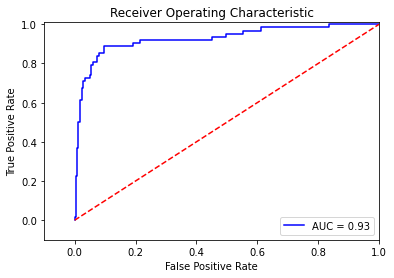

In [135]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_score)
roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('figures/ROC_graph.png')

### Decision Tree Classifier

In [107]:
dtc = DecisionTreeClassifier(random_state = 37)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
data_report = pd.DataFrame(report).transpose()
print(data_report)
print("\nConfusion Matrix\n",confusion_matrix(y_test, y_pred))

              precision    recall  f1-score     support
0              0.982289  0.986320  0.984300  731.000000
1              0.830508  0.790323  0.809917   62.000000
accuracy       0.970996  0.970996  0.970996    0.970996
macro avg      0.906399  0.888321  0.897109  793.000000
weighted avg   0.970422  0.970996  0.970666  793.000000

Confusion Matrix
 [[721  10]
 [ 13  49]]


In [108]:
params = {
    "criterion" : ["gini", "entropy"],
    "splitter" : ["best", "random"],
}

gscv = GridSearchCV(estimator=dtc, param_grid = params, cv = cv, scoring = "accuracy", verbose = 3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....criterion=gini, splitter=best;, score=0.968 total time=   0.0s
[CV 2/5] END .....criterion=gini, splitter=best;, score=0.968 total time=   0.0s
[CV 3/5] END .....criterion=gini, splitter=best;, score=0.968 total time=   0.0s
[CV 4/5] END .....criterion=gini, splitter=best;, score=0.973 total time=   0.0s
[CV 5/5] END .....criterion=gini, splitter=best;, score=0.959 total time=   0.0s
[CV 1/5] END ...criterion=gini, splitter=random;, score=0.959 total time=   0.0s
[CV 2/5] END ...criterion=gini, splitter=random;, score=0.959 total time=   0.0s
[CV 3/5] END ...criterion=gini, splitter=random;, score=0.959 total time=   0.0s
[CV 4/5] END ...criterion=gini, splitter=random;, score=0.935 total time=   0.0s
[CV 5/5] END ...criterion=gini, splitter=random;, score=0.932 total time=   0.0s
[CV 1/5] END ..criterion=entropy, splitter=best;, score=0.968 total time=   0.0s
[CV 2/5] END ..criterion=entropy, splitter=best;,

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=37),
             param_grid={'criterion': ['gini', 'entropy'],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=3)

In [109]:
dtc = DecisionTreeClassifier(criterion=gscv.best_params_["criterion"], splitter=gscv.best_params_["splitter"], random_state = 42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
data_report = pd.DataFrame(report).transpose()
print(data_report)

print("\nConfusion Matrix\n",confusion_matrix(y_test, y_pred))

              precision    recall  f1-score     support
0              0.982167  0.979480  0.980822  731.000000
1              0.765625  0.790323  0.777778   62.000000
accuracy       0.964691  0.964691  0.964691    0.964691
macro avg      0.873896  0.884901  0.879300  793.000000
weighted avg   0.965237  0.964691  0.964947  793.000000

Confusion Matrix
 [[716  15]
 [ 13  49]]


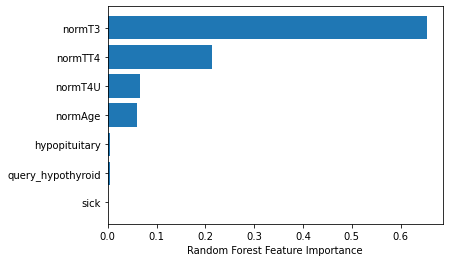

In [136]:
sorted_idx = dtc.feature_importances_.argsort()
plt.barh(data.columns[sorted_idx], dtc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.savefig('figures/important_features.png')

## Hidden Markov Model

### Selecionamento das features a utilizar no modelo

In [481]:
hmm_features = ["normT3", "normTT4"]

In [482]:
hmm_data = data[hmm_features].copy()
hmm_data

,normT3,normTT4
0,0.605651,0.483484
4,-0.972673,-1.321686
7,-1.701131,-0.785776
8,0.241423,0.427073
9,-0.487035,-0.701159
...,...,...
3766,0.848471,0.003986
3768,0.120013,0.455278
3769,-0.244216,0.116809
3770,-0.001396,-0.729364


### Classificar os parâmetros

In [483]:
def categoryClassification(dataframe):

    for feature in dataframe.columns:
        if (feature == 'normT3'):
            Q1 = np.percentile(dataframe[feature], 30)
            Q3 = np.percentile(dataframe[feature], 77.60121074536511)
        if (feature == 'normTT4'):
            Q1 = np.percentile(dataframe[feature], 30.53764661369656)
            Q3 = np.percentile(dataframe[feature], 76.04994324631102)
        L_indexes = dataframe.loc[dataframe[feature] <= Q1, feature].index
        M_indexes = dataframe.loc[(dataframe[feature] > Q1) & (dataframe[feature] <= Q3), feature].index
        H_indexes = dataframe.loc[dataframe[feature] > Q3, feature].index

        dataframe.loc[L_indexes, feature] = "L"
        dataframe.loc[M_indexes, feature] = "M"
        dataframe.loc[H_indexes, feature] = "H"

    return dataframe.copy()

In [484]:
hmm_data = categoryClassification(hmm_data.copy())
hmm_data

,normT3,normTT4
0,H,M
4,L,L
7,L,L
8,M,M
9,L,L
...,...,...
3766,H,M
3768,M,M
3769,M,M
3770,M,L


In [485]:
hmm_data["Class"] = np.zeros(hmm_data.shape[0])
hmm_data.loc[data["Class"] == 0, "Class"] = "N"
hmm_data.loc[data["Class"] == 1, "Class"] = "P"
print("Quantidade de classes classificadas como N:", hmm_data[hmm_data.Class == "N"].shape[0])
print("Quantidade de classes classificadas como P:", hmm_data[hmm_data.Class == "P"].shape[0])
print(hmm_data)

Quantidade de classes classificadas como N: 2431
Quantidade de classes classificadas como P: 212
     normT3 normTT4 Class
0         H       M     N
4         L       L     N
7         L       L     P
8         M       M     N
9         L       L     N
...     ...     ...   ...
3766      H       M     N
3768      M       M     N
3769      M       M     N
3770      M       L     N
3771      M       M     N

[2643 rows x 3 columns]


### Contar o número de ocorrências das sequências (transições)

In [486]:
seq_counter = {}
transition_prob = {}
for i in range(hmm_data.shape[0] - 1):
    current_Class = hmm_data["Class"].values[i]
    next_Class = hmm_data["Class"].values[i + 1]
    seq = current_Class + next_Class

    if seq not in seq_counter:
        seq_counter[seq] = 1
    else:
        seq_counter[seq] += 1
        
transition_prob["NN"] = seq_counter["NN"]/(seq_counter["NN"] + seq_counter["NP"])
transition_prob["NP"] = seq_counter["NP"]/(seq_counter["NN"] + seq_counter["NP"])
transition_prob["PN"] = seq_counter["PN"]/(seq_counter["PN"] + seq_counter["PP"])
transition_prob["PP"] = seq_counter["PP"]/(seq_counter["PN"] + seq_counter["PP"])
print(transition_prob)
print("Soma das probabilidades: ",sum(transition_prob.values()))


{'NN': 0.920164609053498, 'NP': 0.07983539094650206, 'PN': 0.9150943396226415, 'PP': 0.08490566037735849}
Soma das probabilidades:  2.0


### Calcular as probabilidades de emissões

In [487]:
 emission_prob = {}

for Class in ["P", "N"]:
    emission_dict = {}
    temp_hmm_data = hmm_data[hmm_data["Class"] == Class].copy()
    
    for normT3, normTT4 in zip(temp_hmm_data["normT3"].values, temp_hmm_data["normTT4"].values):
        seq = normT3 + normTT4
        
        if seq not in emission_dict:
            emission_dict[seq] = 1
        else:
            emission_dict[seq] += 1
    
    emission_prob[Class] = {key: val / temp_hmm_data.shape[0] for key, val in emission_dict.items()}
emission_prob

{'P': {'LL': 0.5330188679245284,
  'LM': 0.33490566037735847,
  'MH': 0.04716981132075472,
  'HH': 0.018867924528301886,
  'LH': 0.05660377358490566,
  'ML': 0.009433962264150943},
 'N': {'HM': 0.08638420403126286,
  'LL': 0.11353352529823119,
  'MM': 0.274372686137392,
  'HH': 0.10695187165775401,
  'LM': 0.10612916495269437,
  'MH': 0.10777457836281365,
  'ML': 0.14849856026326613,
  'LH': 0.03167420814479638,
  'HL': 0.024681201151789386}}

In [488]:
for key, dict_val in emission_prob.items():
    print(key, [np.sum(list(dict_val.values()))])

P [1.0]
N [1.0]


In [489]:
hmm_model = HiddenMarkovModel( name="thyroid sickness" )

In [490]:
start_prob = {key : hmm_data[hmm_data["Class"] == key].shape[0] / hmm_data.shape[0] for key in ["P", "N"]}
print(start_prob)

{'P': 0.0802118804388952, 'N': 0.9197881195611048}


In [491]:
sN = State( DiscreteDistribution(emission_prob["N"]), name="N" ) # 0 
sP = State( DiscreteDistribution(emission_prob["P"]), name="P" ) # 1

In [492]:
hmm_model.add_transition( hmm_model.start, sP, start_prob["P"] )
hmm_model.add_transition( hmm_model.start, sN, start_prob["N"] )

In [493]:
hmm_model.add_transition( sP, sP, transition_prob["PP"])
hmm_model.add_transition( sP, sN, transition_prob["PN"])
hmm_model.add_transition( sN, sN, transition_prob["NN"])
hmm_model.add_transition( sN, sP, transition_prob["NP"])

In [494]:
hmm_model.add_transition( sN, hmm_model.end, 0.1)
hmm_model.add_transition( sP, hmm_model.end, 0.1)

In [495]:
hmm_model.bake( verbose=True )

thyroid sickness : P summed to 1.1, normalized to 1.0
thyroid sickness : N summed to 1.1, normalized to 1.0


In [496]:
X_test_hmm_1 = X_test[hmm_features].copy()
test_hmm = categoryClassification(X_test_hmm_1.copy())
X_test_hmm = [x[0] + x[1] for x in test_hmm.values]

In [497]:
hmm_predictions = hmm_model.predict(np.array(X_test_hmm))

## Previsões

In [498]:
hmm_dtc_pred = pd.DataFrame({"Sequence" : X_test_hmm, "Class": y_test.values, "DTC predictions" : y_pred, "HMM predictions" : hmm_predictions})
print(hmm_dtc_pred)

    Sequence  Class  DTC predictions  HMM predictions
0         LM      0                0                0
1         ML      0                0                0
2         LL      0                0                0
3         ML      0                0                0
4         ML      0                0                0
..       ...    ...              ...              ...
788       LH      0                0                0
789       ML      0                0                0
790       MM      0                0                0
791       MH      0                1                0
792       HL      0                0                0

[793 rows x 4 columns]


## Accuracy

In [499]:
print("Accuracy de HMM: ",hmm_dtc_pred[hmm_dtc_pred["Class"] == hmm_dtc_pred["HMM predictions"]].shape[0] / hmm_dtc_pred.shape[0])

Accuracy de HMM:  0.9218158890290038
